# **NYC Restaurant Inspections Viz**

Joe Lardie

September 2023

# **Imports**

In [1]:
#Numpy
import numpy as np

#Pandas
import pandas as pd

#Seaborn
import seaborn as sns

#matplotlib
import matplotlib.pyplot as plt
import plotly
%matplotlib inline

from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords

#Sklearn preprocessing
from sklearn import preprocessing,set_config
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder,StandardScaler,LabelEncoder

#Scipy
from scipy import stats
from scipy.stats import norm

# Warnings
import warnings
warnings.filterwarnings("ignore")
set_config(display = 'diagram')

# **Data Dictionary**
**DBA**	This field represents the name (doing business as) of the entity (restaurant); Public business name, may change at discretion of restaurant owner

**BORO**	Borough in which the entity (restaurant) is located.;• 1 = MANHATTAN • 2 = BRONX • 3 = BROOKLYN • 4 = QUEENS • 5 = STATEN ISLAND • Missing; NOTE: There may be discrepancies between zip code and listed boro due to differences in an establishment's mailing address and physical location

**BUILDING**  Building number for establishment (restaurant) location

**STREET**	Street name for establishment (restaurant) location

**ZIPCODE**	Zip code of establishment (restaurant) location

**PHONE**	Phone Number; Phone number provided by restaurant owner/manager

**CUISINE DESCRIPTION**	This field describes the entity (restaurant) cuisine. ; Optional field provided by provided by restaurant owner/manager

**INSPECTION DATE**	This field represents the date of inspection; NOTE: Inspection dates of 1/1/1900 mean an establishment has not yet had an inspection

**ACTION**	This field represents the actions that is associated with each restaurant inspection. ; • Violations were cited in the following area(s). • No violations were recorded at the time of this inspection. • Establishment re-opened by DOHMH • Establishment re-closed by DOHMH • Establishment Closed by DOHMH. Violations were cited in the following area(s) and those requiring immediate action were addressed. • "Missing" = not yet inspected;

**VIOLATION CODE**	Violation code associated with an establishment (restaurant) inspection

**VIOLATION DESCRIPTION**Violation description associated with an establishment (restaurant) inspection

**CRITICAL FLAG**	Indicator of critical violation; "• Critical • Not Critical • Not Applicable"; Critical violations are those most likely to contribute to food-borne illness

**SCORE**Total score for a particular inspection; Scores are updated based on adjudication results

**GRADE**	Grade associated with the inspection; • N = Not Yet Graded• A = Grade A• B = Grade B• C = Grade C• Z = Grade Pending• P= Grade Pending issued on re-opening following an initial inspection that resulted in a closure

**GRADE DATE**	The date when the current grade was issued to the entity (restaurant)

**RECORD DATE**	The date when the extract was run to produce this data set

**INSPECTION TYPE** A combination of the inspection program and the type of inspection performed; See Data Dictionary for full list of expected values


## **Important Context**

RECORD DATE = (date of the data pull).

Restaurants that received no violations are represented by a single row and coded as having no violations using the ACTION field.

Establishments with inspection date of 1/1/1900 are new establishments that have not yet received an inspection.

Keep in mind that thousands of restaurants start business and go out of business every year; only restaurants in an active status are included in the dataset.

Establishments are uniquely identified by their CAMIS (record ID) number.

# **Import Data**

In [2]:
# Loading NYC Restaraunt Data
rdf = pd.read_csv('rdf')

In [3]:
# Glance of inspection data
rdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211180 entries, 0 to 211179
Data columns (total 19 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   CAMIS                  211180 non-null  int64  
 1   DBA                    210501 non-null  object 
 2   BORO                   211180 non-null  object 
 3   BUILDING               210883 non-null  object 
 4   STREET                 211177 non-null  object 
 5   ZIPCODE                208492 non-null  float64
 6   CUISINE DESCRIPTION    208713 non-null  object 
 7   INSPECTION DATE        211180 non-null  object 
 8   ACTION                 208713 non-null  object 
 9   VIOLATION CODE         207585 non-null  object 
 10  VIOLATION DESCRIPTION  207585 non-null  object 
 11  CRITICAL FLAG          211180 non-null  object 
 12  SCORE                  201018 non-null  float64
 13  GRADE                  103218 non-null  object 
 14  GRADE DATE             94397 non-nul

- Grade date has the fewest amount of values

# **Data Cleaning**

## **Function to clean up names**

In [4]:
# Function to clean restaurant names
def clean_restaurant_name(name):
    # Check if the input is a string
    if isinstance(name, str):
        # Remove store numbers using regular expression
        cleaned_name = re.sub(r'#\d+', '', name)
        
        # Remove all numeric characters
        cleaned_name = re.sub(r'\d+', '', cleaned_name)
    
        # Remove leading and trailing whitespace
        cleaned_name = cleaned_name.strip()
    
        return cleaned_name
    else:
        return name  # Return the input unchanged for non-string values

# Apply the clean_restaurant_name function to the 'DBA' column
rdf['Cleaned Restaurant Name'] = rdf['DBA'].apply(clean_restaurant_name)

In [5]:
# checking missing data in data 
def check_missing_data(rdf):
    total = rdf.isnull().sum().sort_values(ascending = False)
    percent = (rdf.isnull().sum()/rdf.isnull().count()*100).sort_values(ascending = False)
    percent = percent.round(2).astype(str) + '%'
    missing_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data
missing_data_result = check_missing_data(rdf)
missing_data_result.head()

,Total,Percent
GRADE DATE,116783,55.3%
GRADE,107962,51.12%
SCORE,10162,4.81%
VIOLATION DESCRIPTION,3595,1.7%
VIOLATION CODE,3595,1.7%


Grade, Score, and Grade date - missing a lot of data due to some places not yet receiving an inspection
DBA needs to reference CAMIS to ensure the situation surrounding the repeated rows
Inspection Type may be related to places not yet received an inspection


In [6]:
# Checking for duplicates
rdf.duplicated().sum()

6

In [7]:
# Checking out the Score column
rdf['SCORE'].describe()

count    201018.000000
mean         22.950437
std          17.610232
min           0.000000
25%          11.000000
50%          19.000000
75%          31.000000
max         168.000000
Name: SCORE, dtype: float64

In [8]:
# Checking most commomn inspection type
rdf['INSPECTION TYPE'].value_counts()

Cycle Inspection / Initial Inspection                          114654
Cycle Inspection / Re-inspection                                37107
Pre-permit (Operational) / Initial Inspection                   31625
Pre-permit (Operational) / Re-inspection                         9616
Administrative Miscellaneous / Initial Inspection                5108
Pre-permit (Non-operational) / Initial Inspection                2695
Pre-permit (Operational) / Compliance Inspection                 1612
Cycle Inspection / Reopening Inspection                          1394
Administrative Miscellaneous / Re-inspection                      987
Cycle Inspection / Compliance Inspection                          827
Pre-permit (Operational) / Reopening Inspection                   720
Smoke-Free Air Act / Initial Inspection                           548
Trans Fat / Initial Inspection                                    393
Calorie Posting / Initial Inspection                              332
Inter-Agency Task Fo

## **Grade Date by Year**

In [9]:
# Convert the 'GRADE DATE' column to datetime type
rdf['GRADE DATE'] = pd.to_datetime(rdf['GRADE DATE'])

# Filter rows for the year 2016
desired_year = 2016 
filtered_df = rdf[rdf['GRADE DATE'].dt.year == desired_year]

# Display the rows for the specified year
print(filtered_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 267 to 210511
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   CAMIS                    263 non-null    int64         
 1   DBA                      263 non-null    object        
 2   BORO                     263 non-null    object        
 3   BUILDING                 256 non-null    object        
 4   STREET                   263 non-null    object        
 5   ZIPCODE                  200 non-null    float64       
 6   CUISINE DESCRIPTION      263 non-null    object        
 7   INSPECTION DATE          263 non-null    object        
 8   ACTION                   263 non-null    object        
 9   VIOLATION CODE           226 non-null    object        
 10  VIOLATION DESCRIPTION    226 non-null    object        
 11  CRITICAL FLAG            263 non-null    object        
 12  SCORE                    263 no

In [10]:
# Convert the 'GRADE DATE' column to datetime type
rdf['INSPECTION DATE'] = pd.to_datetime(rdf['INSPECTION DATE'])

# Filter rows for the year
desired_year = 2023
filtered_df = rdf[rdf['INSPECTION DATE'].dt.year == desired_year]

# Display the rows for the specified year
print(filtered_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85191 entries, 31 to 211178
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   CAMIS                    85191 non-null  int64         
 1   DBA                      85191 non-null  object        
 2   BORO                     85191 non-null  object        
 3   BUILDING                 85127 non-null  object        
 4   STREET                   85191 non-null  object        
 5   ZIPCODE                  84320 non-null  float64       
 6   CUISINE DESCRIPTION      85191 non-null  object        
 7   INSPECTION DATE          85191 non-null  datetime64[ns]
 8   ACTION                   85191 non-null  object        
 9   VIOLATION CODE           84750 non-null  object        
 10  VIOLATION DESCRIPTION    84750 non-null  object        
 11  CRITICAL FLAG            85191 non-null  object        
 12  SCORE                    81236

# **Visualizations**

## **Scores**

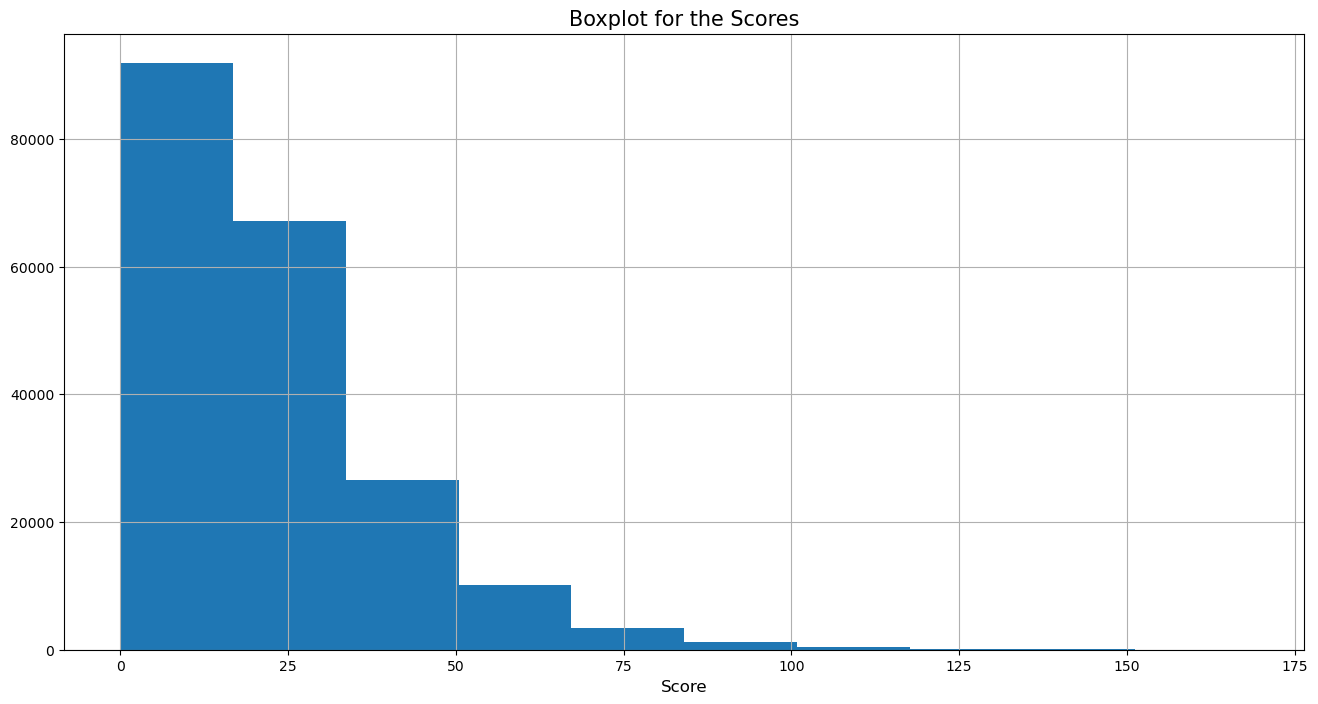

In [11]:
# Plot a histogram
rdf.SCORE.hist(figsize=(16,8))
plt.title("Boxplot for the Scores", fontsize=15)
plt.xlabel('Score', fontsize = 12);

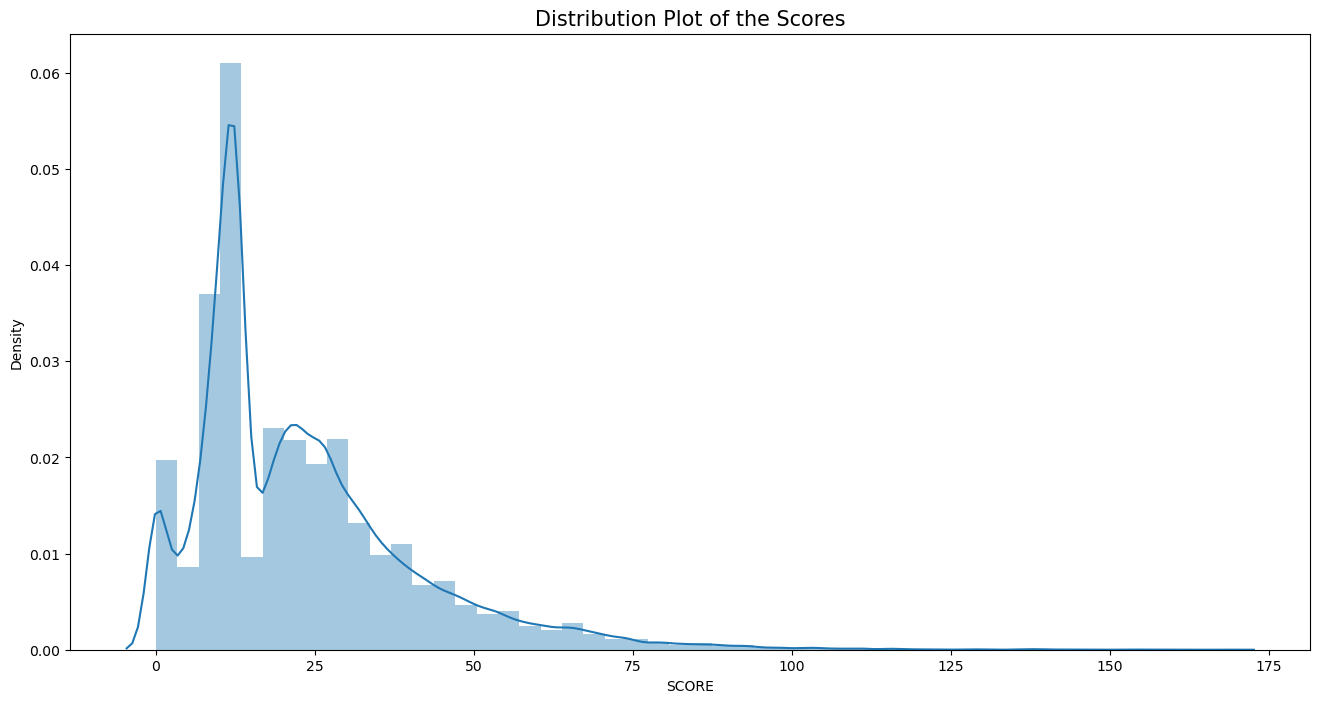

In [12]:
# Have a look at a distribution plot of the Score
fig, ax = plt.subplots()
fig.set_size_inches(16,8)
sns.distplot(rdf.SCORE.dropna())
plt.title("Distribution Plot of the Scores", fontsize=15);

## **NYC Boros**

### **Important Context:**

Establishments with inspection date of 1/1/1900 are new establishments that have not yet received an inspection.

In [13]:
# Filter rows where 'BORO' is 0
f_df = rdf[rdf['BORO'] != '0']

# Display the filtered DataFrame
print(f_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 211171 entries, 0 to 211179
Data columns (total 20 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   CAMIS                    211171 non-null  int64         
 1   DBA                      210499 non-null  object        
 2   BORO                     211171 non-null  object        
 3   BUILDING                 210877 non-null  object        
 4   STREET                   211171 non-null  object        
 5   ZIPCODE                  208486 non-null  float64       
 6   CUISINE DESCRIPTION      208713 non-null  object        
 7   INSPECTION DATE          211171 non-null  datetime64[ns]
 8   ACTION                   208713 non-null  object        
 9   VIOLATION CODE           207585 non-null  object        
 10  VIOLATION DESCRIPTION    207585 non-null  object        
 11  CRITICAL FLAG            211171 non-null  object        
 12  SCORE           

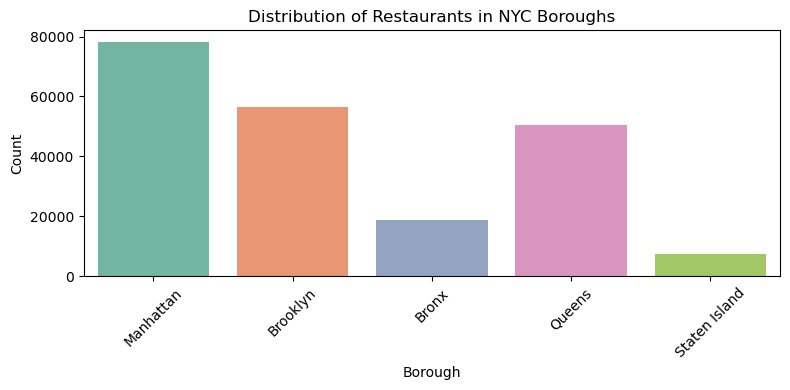

In [14]:
# Visualizing Distribution of Restaurants in NYC Boroughs
plt.figure(figsize=(8, 4))
sns.countplot(data=f_df, x='BORO', palette='Set2') 
plt.title('Distribution of Restaurants in NYC Boroughs')
plt.xlabel('Borough')
plt.ylabel('Count')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

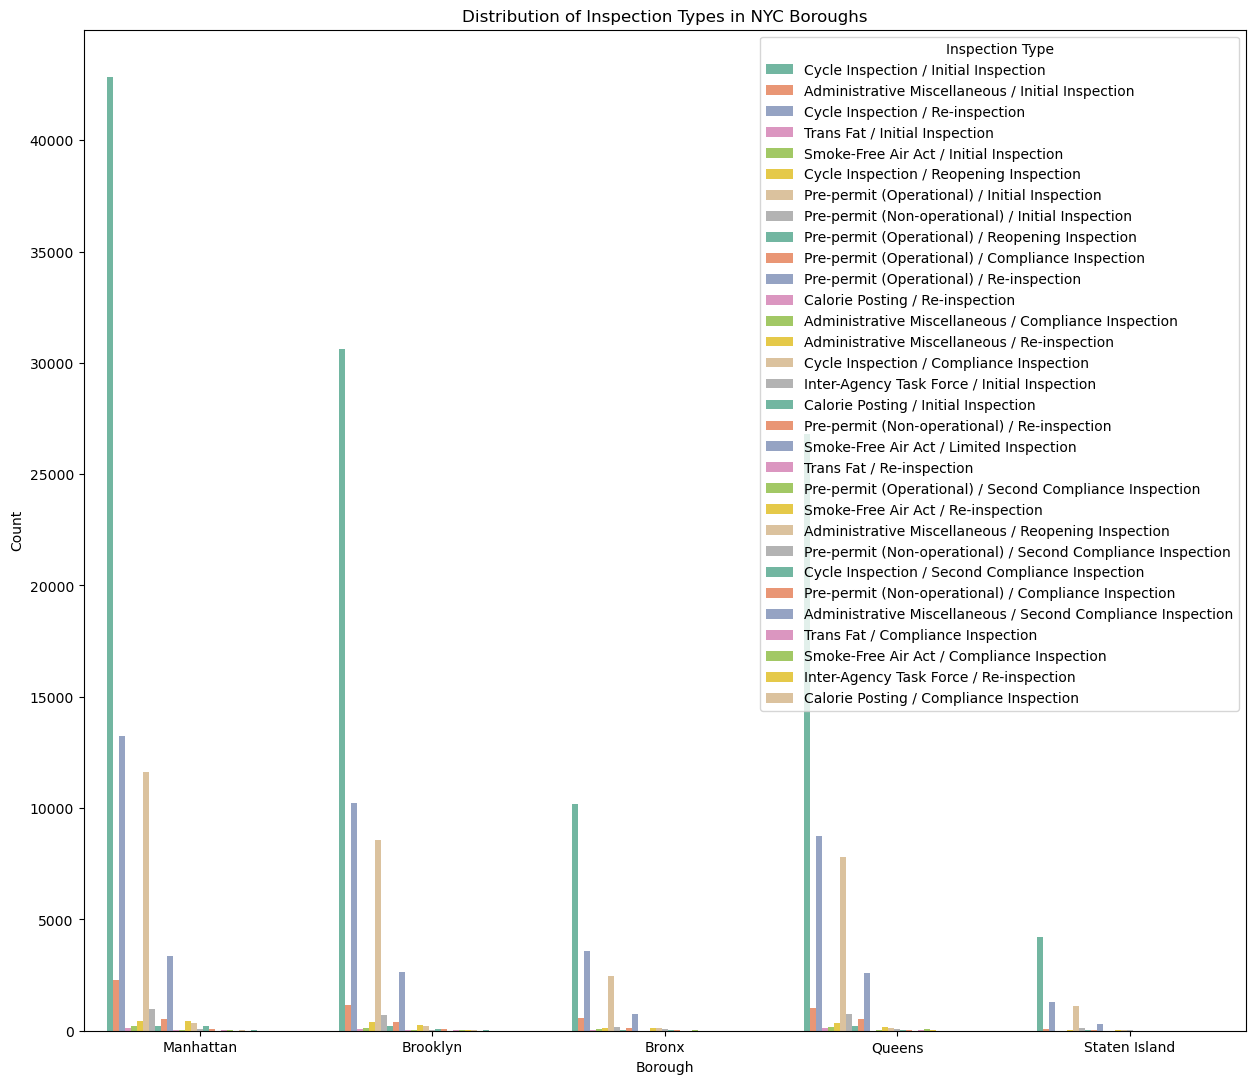

In [15]:
# Create a stacked bar chart using Seaborn
plt.figure(figsize=(15,13))
sns.countplot(x='BORO', hue='INSPECTION TYPE', data=f_df, palette='Set2')
plt.title('Distribution of Inspection Types in NYC Boroughs')
plt.xlabel('Borough')
plt.ylabel('Count')
# Show the plot
plt.legend(title='Inspection Type', bbox_to_anchor=(1, 1), loc='upper right')
plt.show()

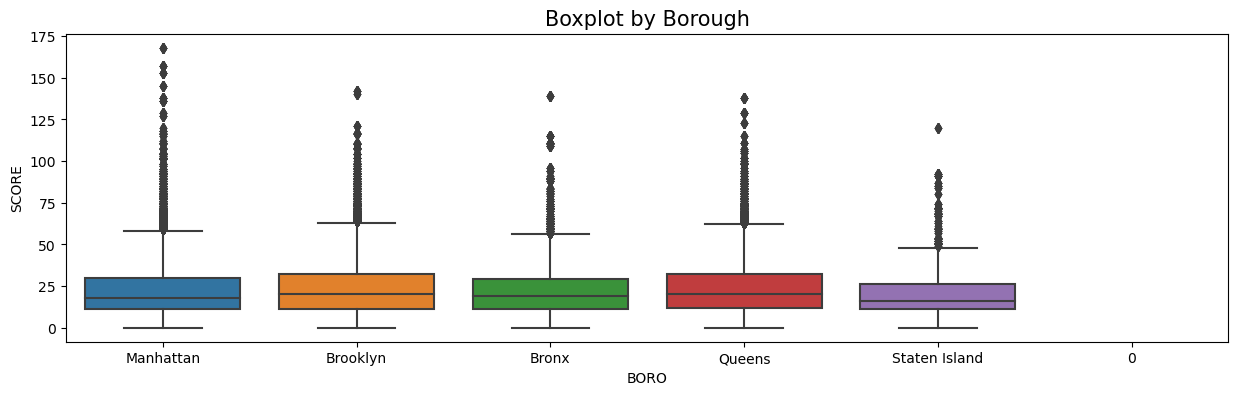

In [16]:
# Create a boxplot using Seaborn
fig, ax = plt.subplots()
fig.set_size_inches(15, 4)
sns.boxplot(x='BORO', y='SCORE', data=rdf)
plt.title('Boxplot by Borough', fontsize=15)

# Show the plot
plt.show()

## **Grade**

In [17]:
# Contingency table for Grade and Borough
boro_grade = pd.crosstab(rdf.GRADE, rdf.BORO, margins = True)
boro_grade

BORO,Bronx,Brooklyn,Manhattan,Queens,Staten Island,All
GRADE,,,,,,
A,6063,18526,27141,16762,2984,71476
B,1181,3097,3972,2931,424,11605
C,592,1922,2444,1890,158,7006
N,740,1939,3541,2322,296,8838
P,47,172,198,137,13,567
Z,439,957,1187,1046,97,3726
All,9062,26613,38483,25088,3972,103218


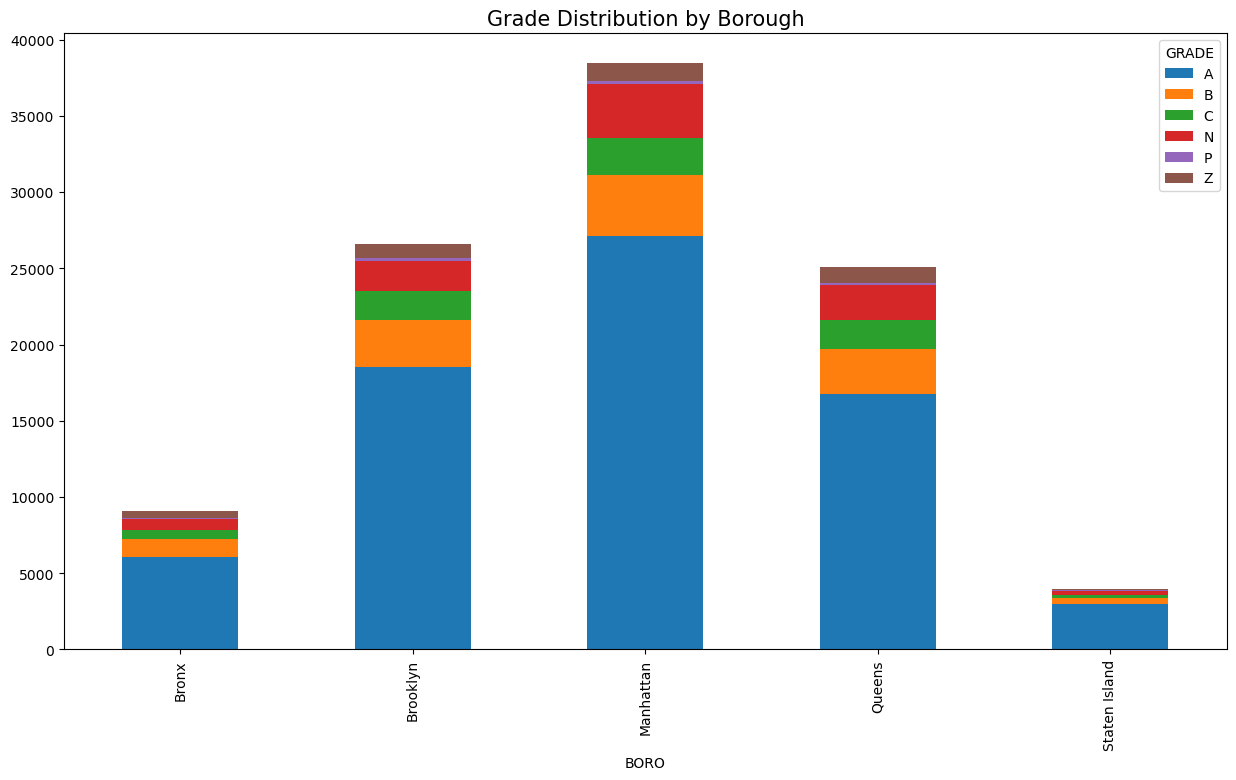

In [18]:
# Plot of grade by borough
pd.crosstab(rdf.BORO, rdf.GRADE).plot(kind="bar", figsize=(15,8), stacked=True)
plt.title('Grade Distribution by Borough', fontsize = 15);

In [19]:
# Test if the grades are independent of the borough
boro_grade.columns = ["BRONX","BROOKLYN","MANHATTAN", "QUEENS", "STATEN ISLAND" ,"All"]

boro_grade.index = ["A","B","C","Not Yet Graded","P", "Z", "All"]

observed = boro_grade.iloc[0:6,0:5]   # Get table without totals for later use

expected =  np.outer(boro_grade["All"][0:6],
                     boro_grade.loc["All"][0:5]) / 1000

expected = pd.DataFrame(expected)

expected.columns = ["BRONX","BROOKLYN","MANHATTAN", "QUEENS", "STATEN ISLAND"]
expected.index = ["A","B","C","Not Yet Graded","P", "Z"]

chi_squared_stat = (((observed-expected)**2)/expected).sum().sum()

print("Chi Squared Stat")
print(chi_squared_stat)

crit = stats.chi2.ppf(q = 0.95, # Find the critical value for 95% confidence*
                      df = 20)   # (5-1) * (6-1)

print("Critical value")
print(crit)

p_value = 1 - stats.chi2.cdf(x=chi_squared_stat,  # Find the p-value
                             df=20)
print("P value")
print(p_value)

stats.chi2_contingency(observed= observed)

Chi Squared Stat
10448523.515404556
Critical value
31.410432844230918
P value
0.0


(411.984795506814,
 6.650252137353933e-75,
 20,
 array([[6.27521859e+03, 1.84288669e+04, 2.66485585e+04, 1.73728409e+04,
         2.75051514e+03],
        [1.01885824e+03, 2.99215122e+03, 4.32671835e+03, 2.82069251e+03,
         4.46579666e+02],
        [6.15090120e+02, 1.80637755e+03, 2.61206280e+03, 1.70286702e+03,
         2.69602511e+02],
        [7.75930128e+02, 2.27872749e+03, 3.29509150e+03, 2.14814997e+03,
         3.40100913e+02],
        [4.97796315e+01, 1.46191275e+02, 2.11395890e+02, 1.37814102e+02,
         2.18191013e+01],
        [3.27123292e+02, 9.60685520e+02, 1.38917299e+03, 9.05635529e+02,
         1.43382666e+02]]))

## **Distribution of Grades**

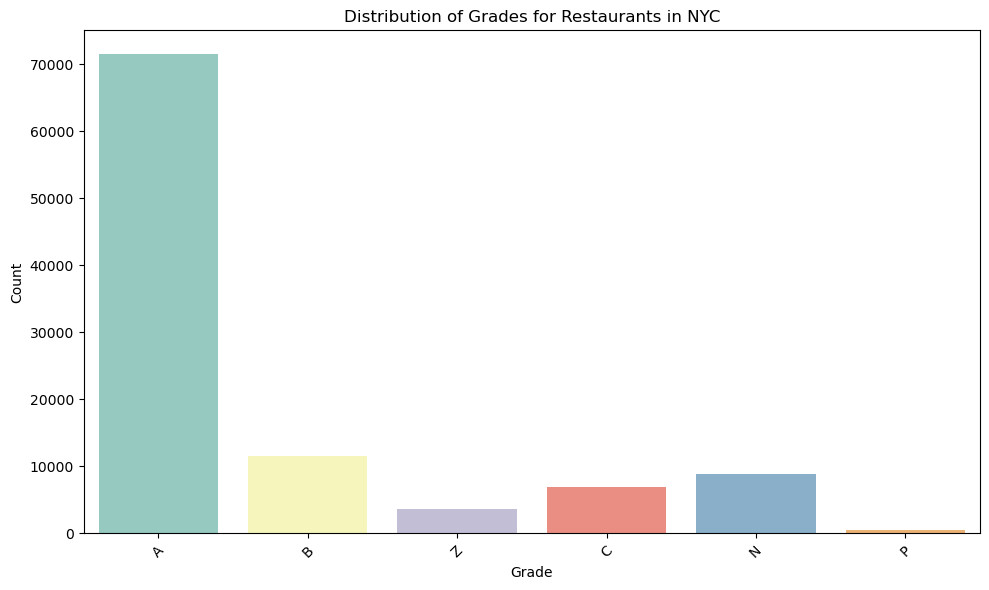

In [20]:
# Visualizing Distribution of Grades for Restaurants in NYC
plt.figure(figsize=(10, 6))
sns.countplot(data=rdf, x='GRADE', palette='Set3')  
plt.title('Distribution of Grades for Restaurants in NYC')
plt.xlabel('Grade')
plt.ylabel('Count')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

**GRADE**	Grade associated with the inspection; • N = Not Yet Graded• A = Grade A• B = Grade B• C = Grade C• Z = Grade Pending• P= Grade Pending issued on re-opening following an initial inspection that resulted in a closure

## **Distribution of Cuisine Types**

In [21]:
# Filteriung out the irrelevant Cuisine Types for Visalization
min_cuisine_count = 1000
cuisine_counts = rdf['CUISINE DESCRIPTION'].value_counts()
filtered_cuisines = cuisine_counts[cuisine_counts >= min_cuisine_count].index
fdf = rdf[rdf['CUISINE DESCRIPTION'].isin(filtered_cuisines)]

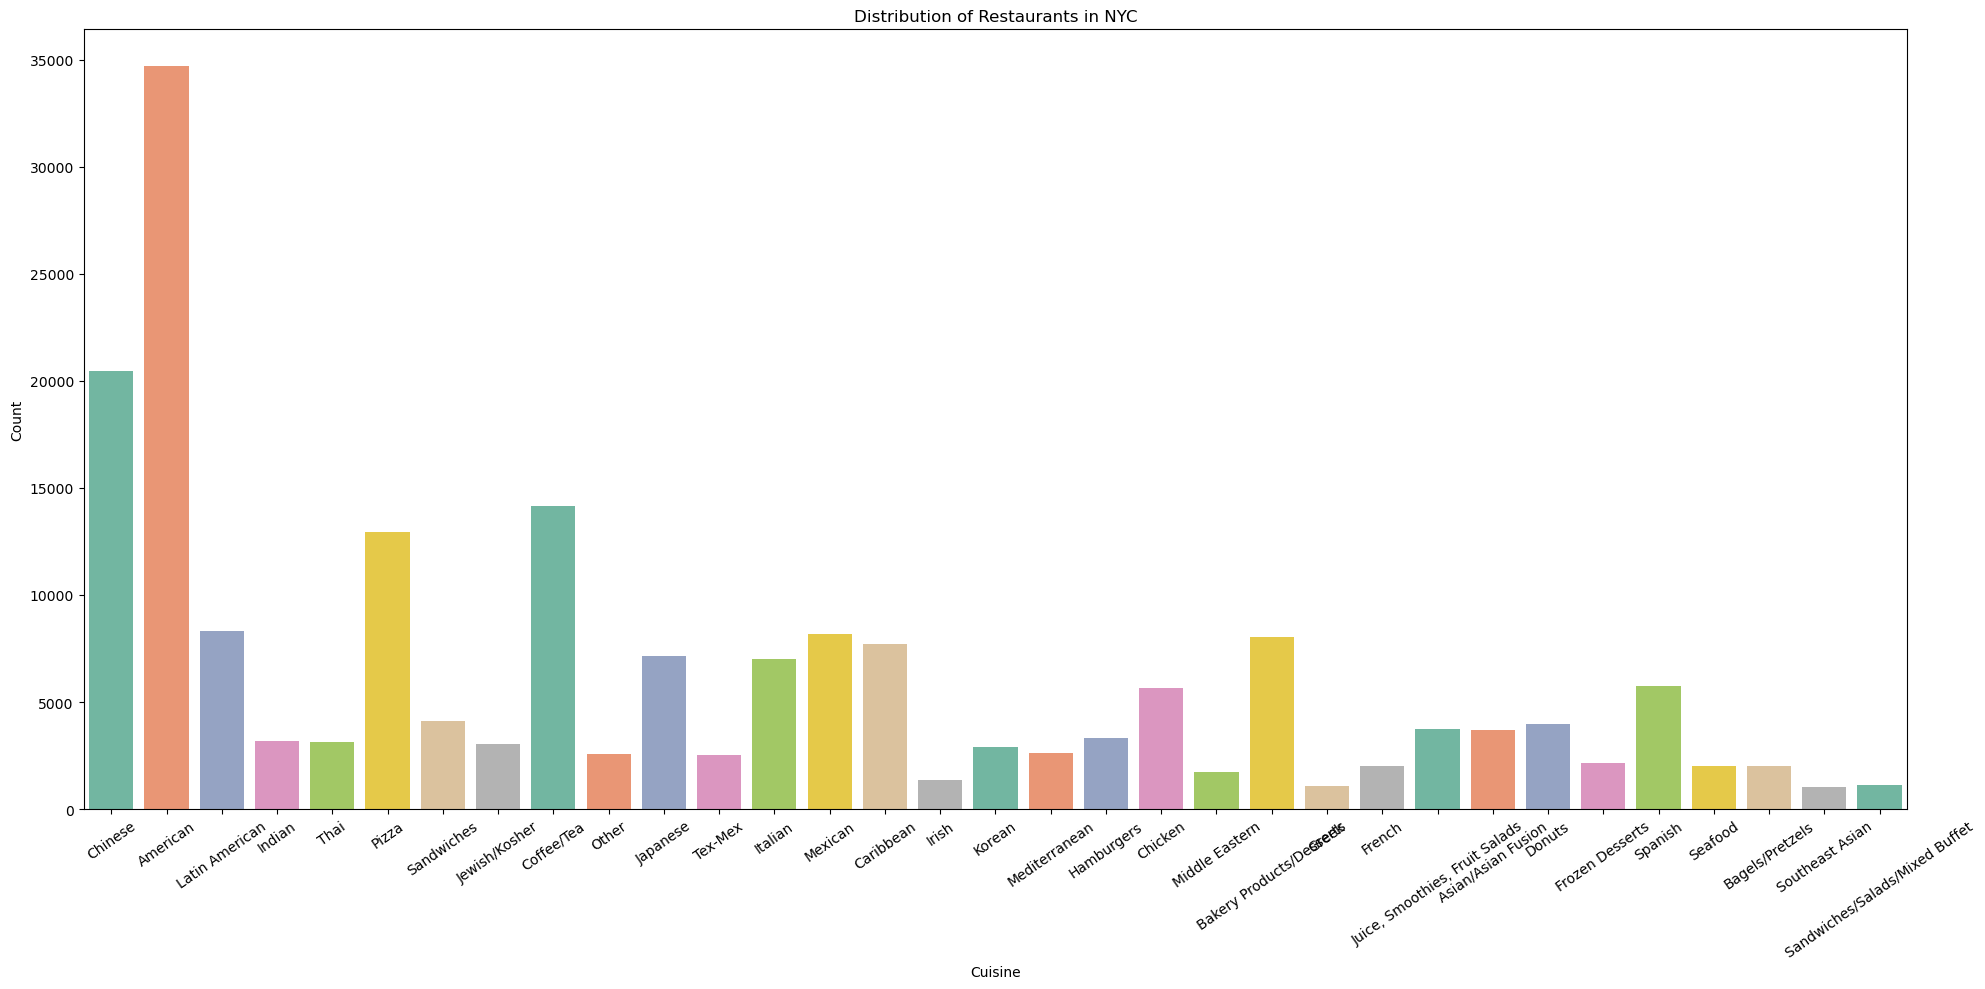

In [22]:
# Visualization of most popular cuisines
plt.figure(figsize=(20,10))
sns.countplot(data=fdf, x='CUISINE DESCRIPTION', palette='Set2') 
plt.title('Distribution of Restaurants in NYC')
plt.xlabel('Cuisine')
plt.ylabel('Count')
plt.xticks(rotation=35) 

plt.tight_layout()
plt.show()

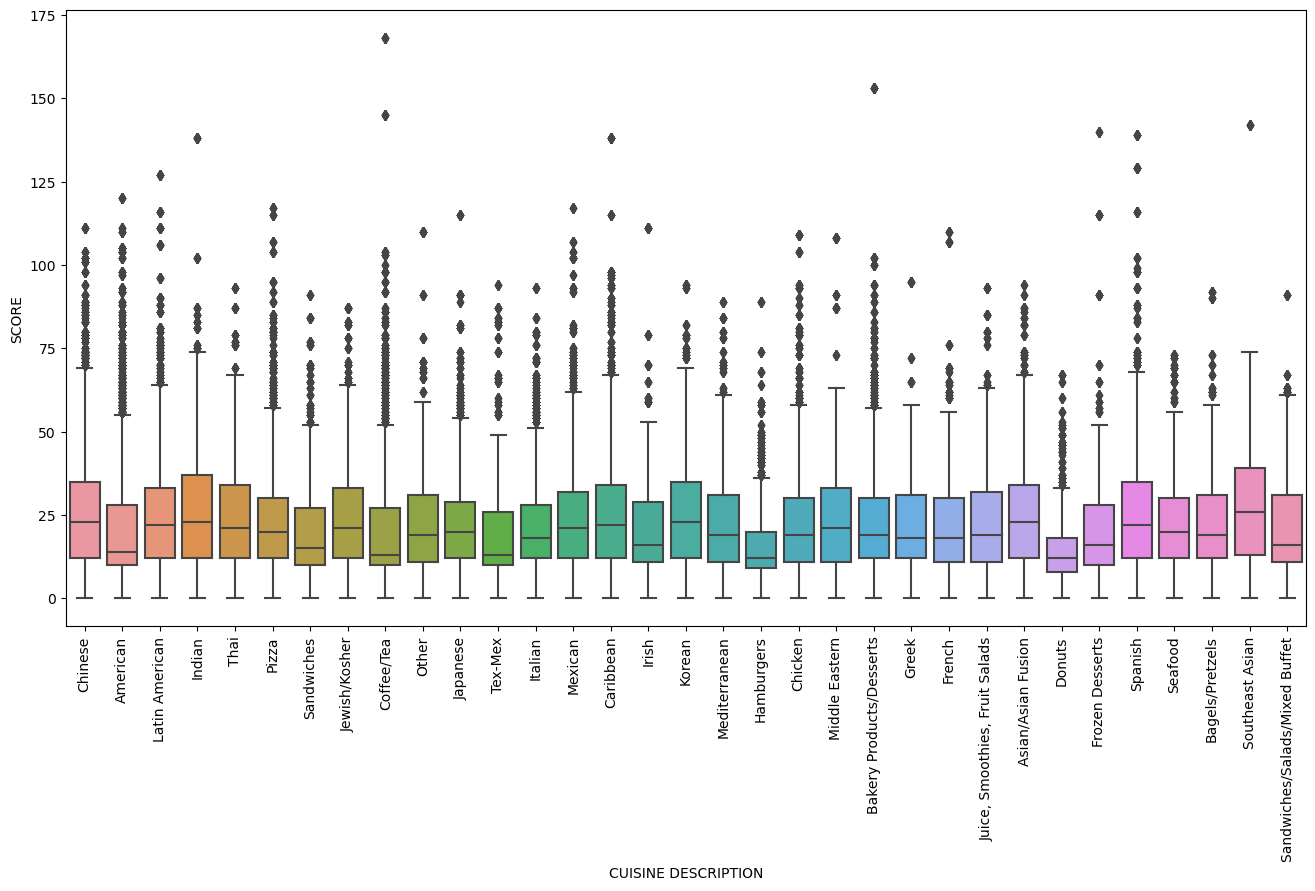

In [23]:
# Let us look at the scores by cuisine
score_cuisine = pd.concat([fdf['CUISINE DESCRIPTION'], fdf['SCORE']], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x = 'CUISINE DESCRIPTION', y="SCORE", data = fdf)
plt.xticks(rotation=90);

## **Critical Flags**

Text(0.5, 1.0, 'Critical Flag by Borough')

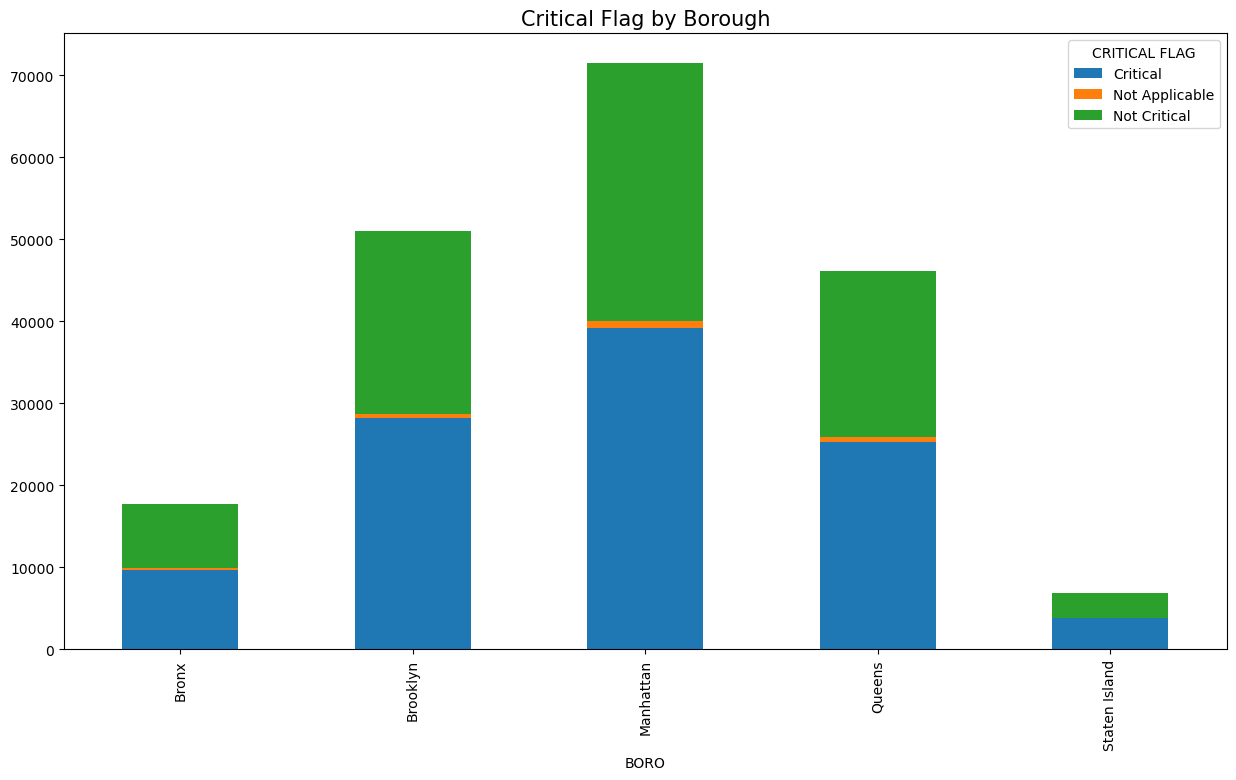

In [24]:
# Critical Flag by Borough
pd.crosstab(fdf.BORO, rdf['CRITICAL FLAG']).plot(kind="bar", figsize=(15,8), stacked=True)
plt.title('Critical Flag by Borough', fontsize = 15)

Text(0.5, 1.0, 'Critical Flag by Cuisine')

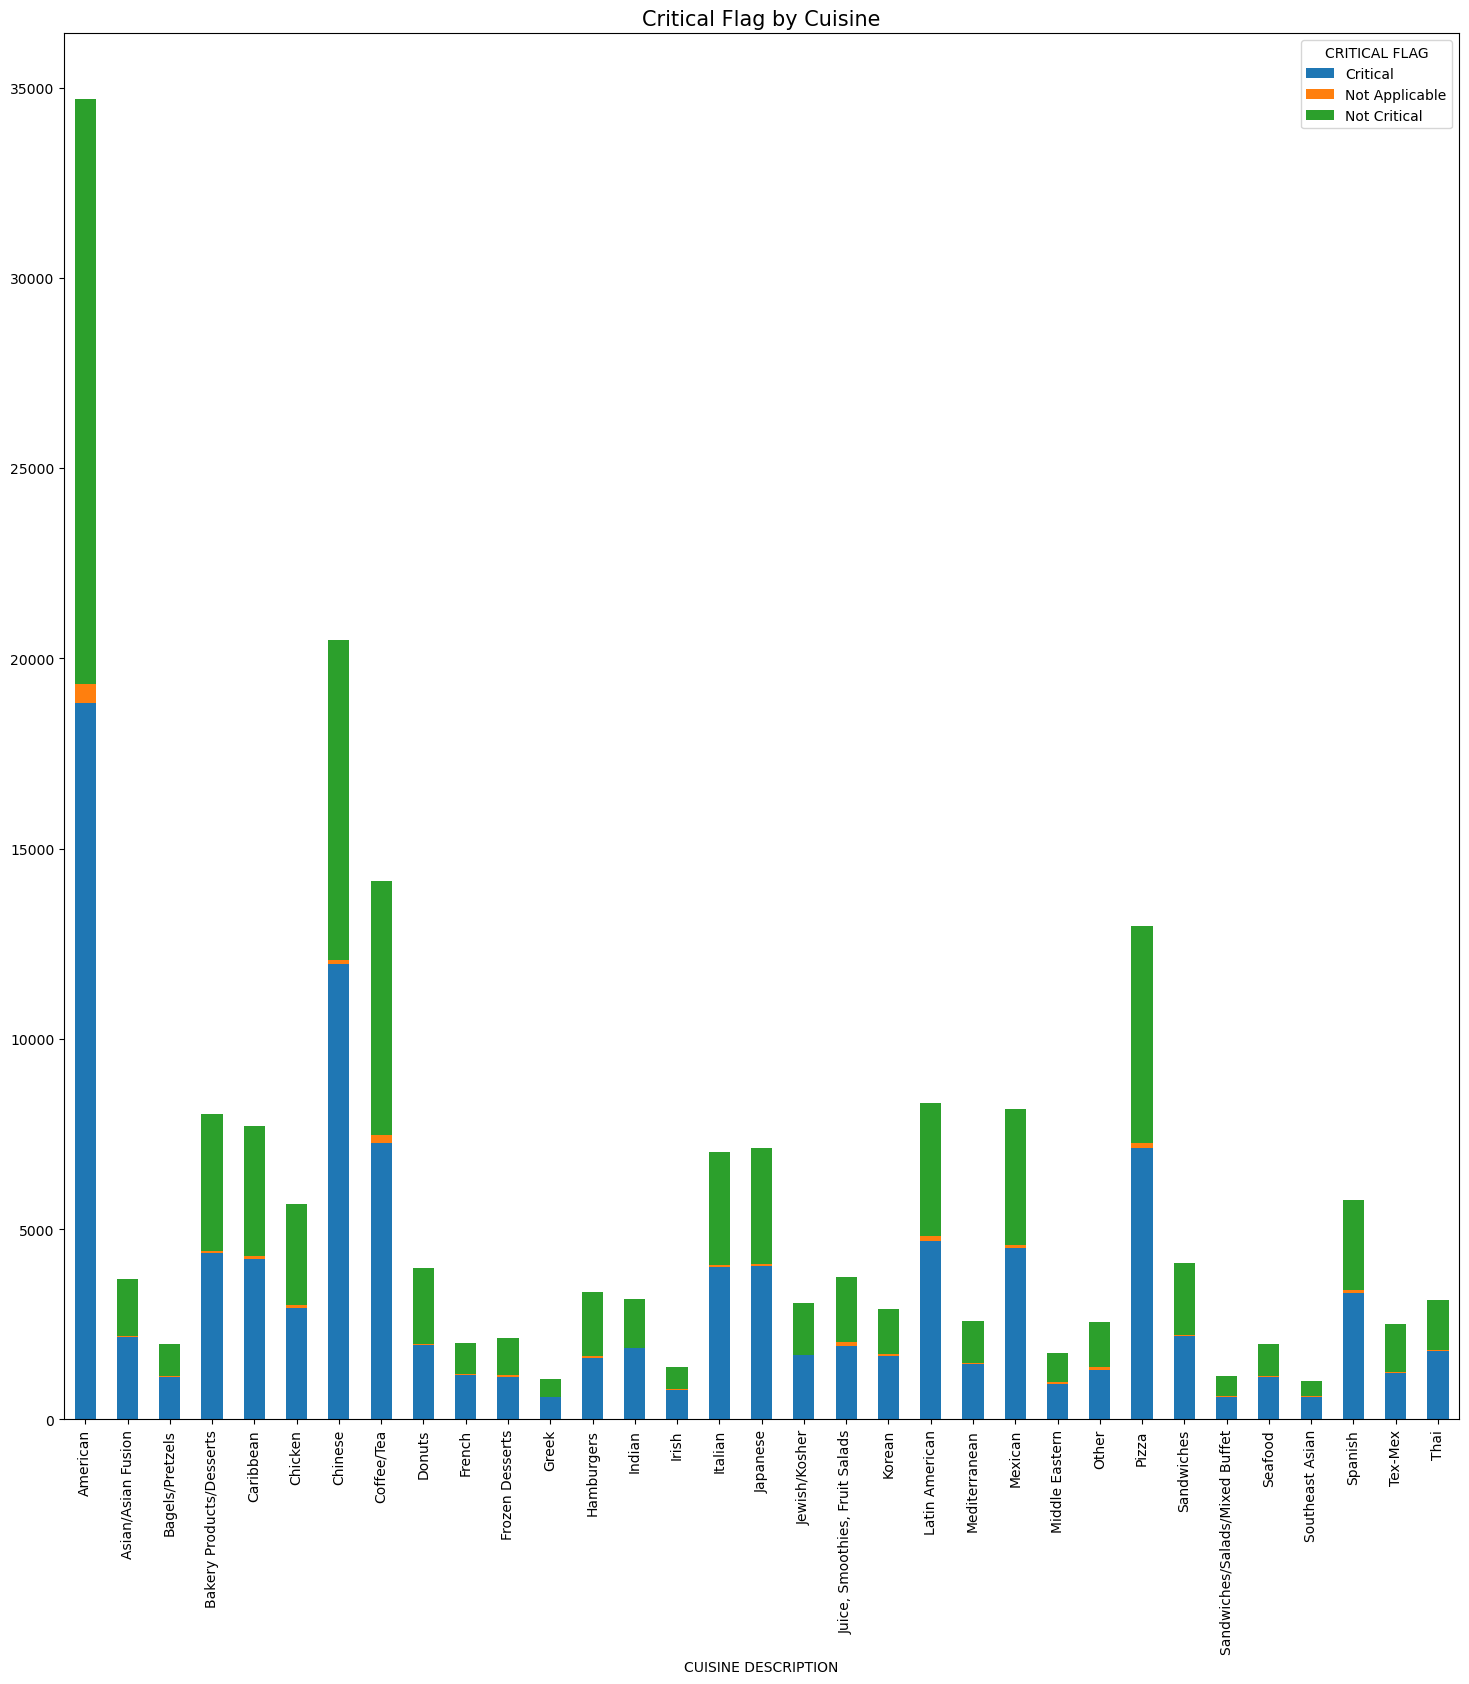

In [25]:
# Critical Flag by Cuisine
pd.crosstab(fdf['CUISINE DESCRIPTION'], fdf['CRITICAL FLAG']).plot(kind="bar", figsize=(18,18), stacked=True)
plt.title('Critical Flag by Cuisine', fontsize = 15)

# **Text Visual**

In [26]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
def text_prepare(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower()# lowercase text  
    text = REPLACE_BY_SPACE_RE.sub(' ',text)# replace REPLACE_BY_SPACE_RE symbols by space in text    
    text = BAD_SYMBOLS_RE.sub('',text)# delete symbols which are in BAD_SYMBOLS_RE from text    
    temp = [s.strip() for s in text.split() if s not in STOPWORDS]# delete stopwords from text
    new_text = ''
    for i in temp:
        new_text +=i+' '
    text = new_text
    return text.strip()

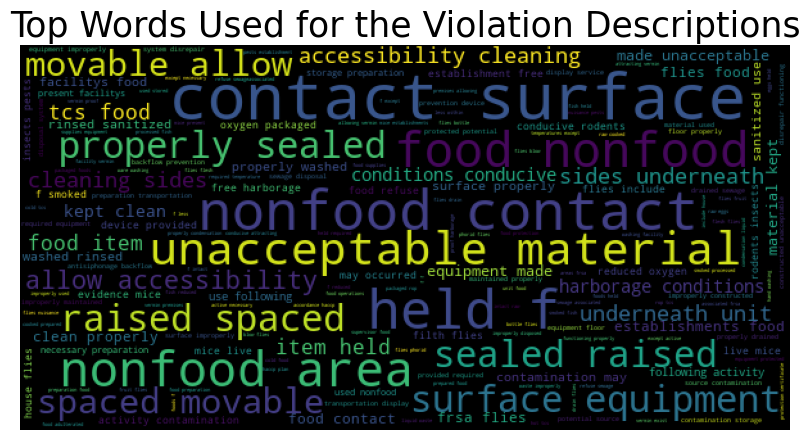

In [27]:
# Creating a word cloud for the violation description
temp_data = rdf.dropna(subset=['VIOLATION DESCRIPTION'])
# Converting into lowercase
temp_data['VIOLATION DESCRIPTION'] = temp_data['VIOLATION DESCRIPTION'].apply(lambda x: " ".join(x.lower() for x in x.split()))
temp_data['VIOLATION DESCRIPTION'] = temp_data['VIOLATION DESCRIPTION'].map(text_prepare)
# Wordcloud visual for most used words for Violation Desriptions
wordcloud = WordCloud(max_font_size=50, width=600, height=300).generate(' '.join(temp_data['VIOLATION DESCRIPTION'].values))
plt.figure(figsize=(15,5))
plt.imshow(wordcloud)
plt.title("Top Words Used for the Violation Descriptions", fontsize=25)
plt.axis("off")
plt.show()